In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from WindPy import w
import scipy.optimize as sco
import datetime
import empyrical
%matplotlib inline

In [181]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [194]:
start_date, end_date = '2016-03-01', datetime.datetime.today() - datetime.timedelta(2)

In [253]:
# df = pd.read_excel(u'../data/主动+行业基金池.xlsx')

In [254]:
# df.head()

In [210]:
# df = df[(df[u'基金类型'] == u'GARP成长') | (df[u'基金类型'] == u'GARP价值')]

In [198]:
# data = w.wsd(df[u'代码'].tolist(), 'nav_adj', start_date, end_date)

In [199]:
# nav = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)

In [252]:
# nav.head()

In [201]:
# nav = nav.dropna(axis=1)

In [202]:
# ret_nav = nav.pct_change().dropna()

In [250]:
# ret = pd.DataFrame()
# for name in df[u'基金类型'].unique():
#     print(name)
#     temp = pd.DataFrame()
#     select_df = df[df[u'基金类型'] == name]
#     for fund_code in select_df[u'代码']:
#         if fund_code in ret_nav.columns:
#             temp[fund_code] = ret_nav[fund_code]
#     ret[name] = temp.mean(axis=1)

In [249]:
# ret.head()

In [251]:
# ret_fund = 0.5 * ret[u'GARP成长'] + 0.5 * ret[u'GARP价值']

In [255]:
codes = '000906.SH,000934.SH,000931.CSI,000933.SH,000935.SH'

In [256]:
data = w.wsd(codes, 'close', start_date, end_date)

In [257]:
df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=[u'中证800', u'金融地产', u'可选消费', u'必选医药', u'信息科技'])

In [258]:
ret = df.pct_change().dropna()

In [259]:
# ret[u'中证800'] = ret_fund

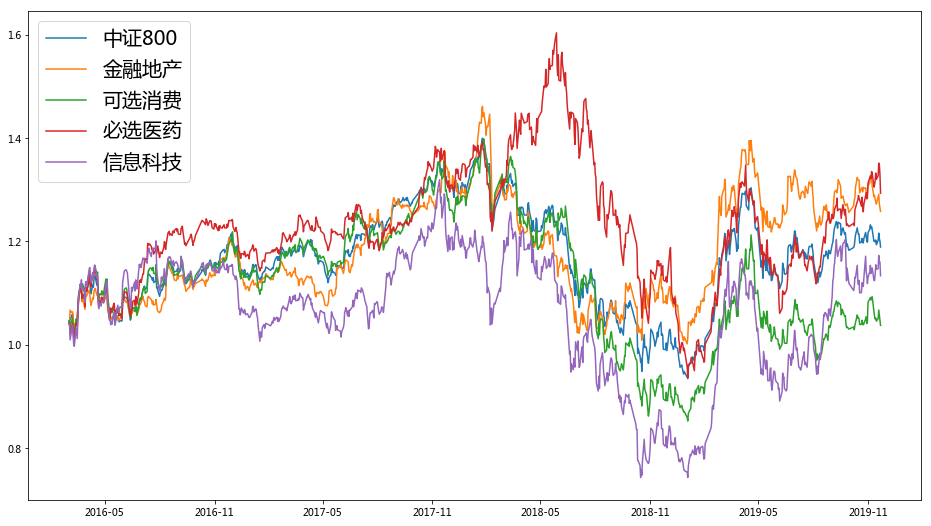

In [260]:
(1 + ret).cumprod().plot(figsize=(16, 9))

plt.legend(fontsize=20)

# 计算最佳比例

In [261]:
mean_daily_returns = ret.mean()
cov_matrix = ret.cov()
num_portfolios = 10000
results = np.zeros((3,num_portfolios))

In [262]:
for i in xrange(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.random.random(ret.shape[1])
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]

In [263]:
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe'])

In [264]:
results_frame.head()

,ret,stdev,sharpe
0,0.078341,0.176380,0.444160
1,0.058676,0.185408,0.316471
2,0.053146,0.183911,0.288977
3,0.068688,0.198213,0.346534
4,0.064307,0.191975,0.334977


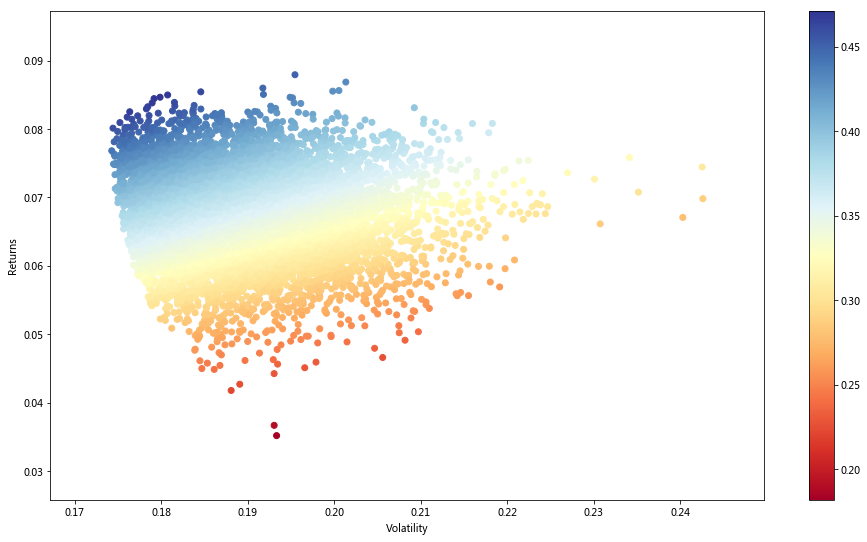

In [265]:
plt.figure(figsize=(16, 9))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

# 组合优化

In [266]:
def calcPortfolioPerf(weights, meanReturns, covMatrix):
    '''
    Calculates the expected mean of returns and volatility for a portolio of
    assets, each carrying the weight specified by weights

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio

    OUTPUT
    tuple containing the portfolio return and volatility
    '''    
    #Calculate return and variance

    portReturn = np.sum( meanReturns*weights ) * 252
    portStdDev = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)

    return portReturn, portStdDev

In [267]:
def negSharpeRatio(weights, meanReturns, covMatrix, riskFreeRate):
    '''
    Returns the negated Sharpe Ratio for the speicified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    p_ret, p_var = calcPortfolioPerf(weights, meanReturns, covMatrix)

    return -(p_ret - riskFreeRate) / p_var

In [268]:
def getPortfolioVol(weights, meanReturns, covMatrix):
    '''
    Returns the volatility of the specified portfolio of assets

    INPUT
    weights: array specifying the weight of each asset in the portfolio
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio

    OUTPUT
    The portfolio's volatility
    '''
    return calcPortfolioPerf(weights, meanReturns, covMatrix)[1]

In [269]:
def findMaxSharpeRatioPortfolio(meanReturns, covMatrix, riskFreeRate):
    '''
    Finds the portfolio of assets providing the maximum Sharpe Ratio

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    riskFreeRate: time value of money
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(negSharpeRatio, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

In [270]:
def findMinVariancePortfolio(meanReturns, covMatrix):
    '''
    Finds the portfolio of assets providing the lowest volatility

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(getPortfolioVol, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts

In [271]:
maxSharpe = findMaxSharpeRatioPortfolio(ret.mean(), ret.cov(), 0.0)

In [272]:
maxSharpe

     fun: -0.49372747564705216
     jac: array([ 1.13613099e-01,  8.54209065e-06,  3.15734122e-01, -8.63894820e-06,
        1.75889954e-01])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.97289870e-16, 5.02612315e-01, 1.04608973e-16, 4.97387685e-01,
       1.10864851e-17])

In [273]:
rp, sdp = calcPortfolioPerf(maxSharpe['x'], ret.mean(), ret.cov())

In [274]:
rp, sdp

(0.08697000251604652, 0.17614981301591207)

In [275]:
minVar = findMinVariancePortfolio(ret.mean(), ret.cov())

In [276]:
minVar

     fun: 0.173932482061301
     jac: array([0.17357051, 0.17410418, 0.17399462, 0.17396725, 0.20830269])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.53542430e-01, 4.80004687e-01, 3.52406318e-03, 2.62928820e-01,
       7.27499658e-17])

In [277]:
rp_min, sdp_min = calcPortfolioPerf(minVar['x'], ret.mean(), ret.cov())

# 寻找有效前沿

In [278]:
def findEfficientReturn(meanReturns, covMatrix, targetReturn):
    '''
    Finds the portfolio of assets providing the target return with lowest
    volatility

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    targetReturn: APR of target expected return

    OUTPUT
    Dictionary of results from optimization
    '''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)

    def getPortfolioReturn(weights):
        return calcPortfolioPerf(weights, meanReturns, covMatrix)[0]

    constraints = ({'type': 'eq', 'fun': lambda x: getPortfolioReturn(x) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(numAssets))

    return sco.minimize(getPortfolioVol, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

In [279]:
def findEfficientFrontier(meanReturns, covMatrix, rangeOfReturns):
    '''
    Finds the set of portfolios comprising the efficient frontier

    INPUT
    meanReturns: mean values of each asset's returns
    covMatrix: covariance of each asset in the portfolio
    targetReturn: APR of target expected return

    OUTPUT
    Dictionary of results from optimization
    '''
    efficientPortfolios = []
    for ret in rangeOfReturns:
        efficientPortfolios.append(findEfficientReturn(meanReturns, covMatrix, ret))

    return efficientPortfolios

In [283]:
targetReturns = np.linspace(rp_min, 0.09, 50)

In [284]:
efficientPortfolios = findEfficientFrontier(ret.mean(), ret.cov(), targetReturns)

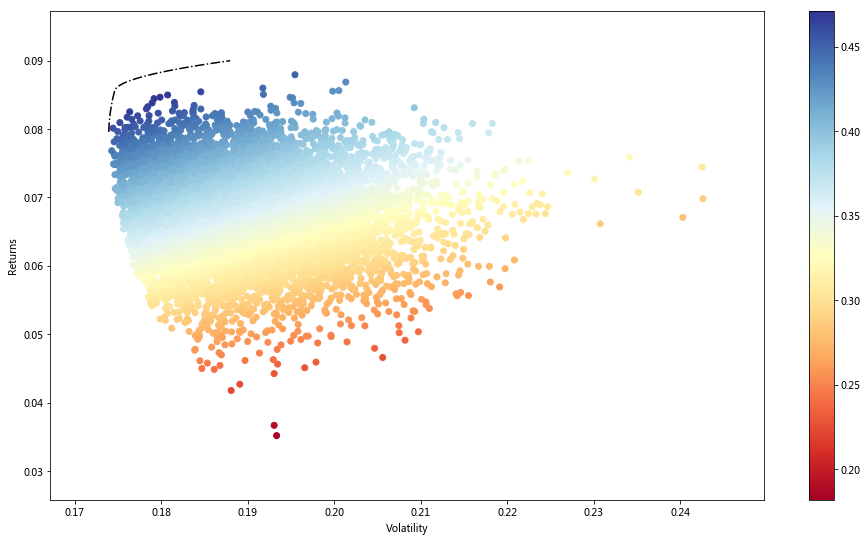

In [285]:
plt.figure(figsize=(16, 9))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.plot([p['fun'] for p in efficientPortfolios], targetReturns, linestyle='-.', color='black', label='efficient frontier')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()

In [286]:
for i, e in enumerate(efficientPortfolios):
    print(e.x[:2].sum(), targetReturns[i])

(0.7303140109055426, 0.07957432572711892)
(0.7316009152824465, 0.07978709458983078)
(0.727350314625162, 0.07999986345254263)
(0.7247187538943686, 0.0802126323152545)
(0.7204306872343336, 0.08042540117796636)
(0.7161425061626017, 0.08063817004067822)
(0.7109980296919416, 0.08085093890339007)
(0.707575841212383, 0.08106370776610193)
(0.7032915508846792, 0.08127647662881379)
(0.6990081469875473, 0.08148924549152566)
(0.6947255894899405, 0.0817020143542375)
(0.6904436713347114, 0.08191478321694937)
(0.6861621635521343, 0.08212755207966123)
(0.6818805160234348, 0.08234032094237309)
(0.6775979112219113, 0.08255308980508494)
(0.673313094370981, 0.0827658586677968)
(0.6690244475438694, 0.08297862753050866)
(0.6647301695063164, 0.08319139639322051)
(0.6604296614643379, 0.08340416525593237)
(0.6561249270671873, 0.08361693411864424)
(0.6518213546566505, 0.0838297029813561)
(0.6480319774185757, 0.08404247184406795)
(0.643772175202159, 0.08425524070677981)
(0.6394771421955429, 0.08446800956949167)


# 业绩基准年化收益率

In [174]:
base_data = w.wsd('000905.SH', 'close', start_date, end_date)

In [175]:
base = pd.DataFrame(np.array(base_data.Data).T, index=base_data.Times, columns=base_data.Codes)

In [176]:
base.pct_change().mean() * 252

000905.SH    0.045448
dtype: float64

In [177]:
res = findEfficientFrontier(ret.mean(), ret.cov(), [base.pct_change().mean() * 252])

In [178]:
res

[     fun: 0.22822596063283854
      jac: array([0.23077649, 0.22651058, 0.23254183, 0.2142059 , 0.24975241])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 9
     njev: 9
   status: 0
  success: True
        x: array([8.46080831e-01, 1.21430643e-17, 2.77555756e-17, 1.53919169e-01,
        0.00000000e+00])]

In [168]:
res[0].x[:2].sum()

0.8735025557557095